In [154]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt

# Utilities and analysis setup

In [2]:
# dict to map node ID to node address
node_map = {
    '1': 'planetlab2.citadel.edu',
    '2': 'planetlab2.c3sl.ufpr.br',
    '3': 'planetlab6.goto.info.waseda.ac.jp',
    '4': 'pl-dccd-01.cua.uam.mx',
    '5': 'planetlab3.rutgers.edu',
    '6': 'planetlab2.ie.cuhk.edu.hk',
    '7': 'planetlab1.temple.edu',
    '8': 'planetlab1.rutgers.edu'
}

node_loc = {
    '1': 'US (Citadel)',
    '2': 'Brazil',
    '3': 'Japan',
    '4': 'Mexico',
    '5': 'US (Rutgers 3)',
    '6': 'Hong Kong',
    '7': 'US (Temple)',
    '8': 'US (Rutgers 1)'
}

node_pairs = {
    '1-2 & 2-1': f"{node_loc['1']} to {node_loc['2']}",
    '1-5 & 5-1': f"{node_loc['1']} to {node_loc['5']}",
    '3-5 & 5-3': f"{node_loc['3']} to {node_loc['5']}",
    '4-7 & 7-4': f"{node_loc['4']} to {node_loc['7']}",
    '6-8 & 8-6': f"{node_loc['6']} to {node_loc['8']}",
}

### Set the current working directory to the project root

In [3]:
os.chdir("/Users/jlahut/UAlbany/comp-comm-networks/final-project/project/")

### Read in data files
Data files have the following format `<type>_<src>-<dest>_<Y-M-D>_<H-M-S>`  
*The timestamps in the file names are local to the node in which it came from*

In [4]:
data = []
print(f"Reading in {len(os.listdir('data/'))} files...")
for filename in os.listdir("data/"):
    try:
        items = filename.split('_')

        measure = items[0]
        src, dest = items[1].split('-')

        date = items[2]
        time = items[3].split('.')[0]

        timestamp = dt.datetime.strptime(f'{date} {time}', '%Y-%m-%d %H-%M-%S')
        content = ''

        with open(os.path.join('data', filename), 'r') as file:
            content = file.read()
            
        if (src == '1' and dest == '2') or (src == '2' and dest == '1'):
            pair = '1-2 & 2-1'
        elif (src == '3' and dest == '5') or (src == '5' and dest == '3'):
            pair = '3-5 & 5-3'
        elif (src == '4' and dest == '7') or (src == '7' and dest == '4'):
            pair = '4-7 & 7-4'
        elif (src == '6' and dest == '8') or (src == '8' and dest == '6'):
            pair = '6-8 & 8-6'
        elif (src == '1' and dest == '5') or (src == '5' and dest == '1'):
            pair = '1-5 & 5-1'
        else:
            pair = 'Error'

        data.append([src, dest, timestamp, measure, node_map[src], node_map[dest], content, filename, pair])
    except:
        print(f'Could not read file: {filename}')

Could not read file: traceroute_-_2019-11-21_01-36-28.txt


### Create 'master' dataframe to hold all raw data

In [5]:
df = pd.DataFrame(data, columns = ['src_id', 'dest_id', 'time', 'measure', 'src_name', 'dest_name', 'raw_data', 'filename', 'pair'])

### Ping and Traceroute functions to be applied accross the dataframe
- Used mainly for file parsing


In [91]:
# example format
# rtt min/avg/max/mdev = 68.244/68.337/68.498/0.129 ms or
# rtt min/avg/max/mdev = 68.244/68.337/68.498/0.129 ms, pipe n
# 20 packets transmitted, 20 received, 0% packet loss, time 19029ms
def analyze_ping(data):
    
    # only worries about ping
    if (data['measure'] != 'ping'):
        return data
    
    try:
        # --- parse out statistics ---
        # second to last line will always be calculated values
        # split on '=' sign, then strip all spaces, remove units, and finally split on '/'
        # giving the values we need
        metrics = data['raw_data'].split('\n')[-2].split('=')[1].strip().replace(' ms', '').split(',')[0].split('/')
        data['min_ping_time'], data['avg_ping_time'], data['max_ping_time'], data['sd_ping_time'] = \
            float(metrics[0]), float(metrics[1]), float(metrics[2]), float(metrics[3])
        
        # --- parse out packet loss ---
        # third to last line will always be the line with packet loss
        data['packet_loss'] = float(data['raw_data'].split('\n')[-3].split(',')[2].split(' ')[1].replace('%', ''))
    except Exception as e:
        print(f"No calculated data for: {data['filename']}")
    return data

def analyze_traceroute(data):
    
    from pprint import pprint
    
    # only worried about traceroute
    if data['measure'] != 'traceroute':
        return data
    
    try:
        traceroute = [x.strip() for x in data['raw_data'].split('\n')]
        routers = [x.split('  ')[1] for x in traceroute if len(x.split('  ')) > 1]
#         print(routers)
        ip_addresses = [x.split(' ')[1].replace('(', '').replace(')', '') for x in routers]
        
        data['num_hops'] = len(routers)
        data['ips'] = ip_addresses
        
        
        
    except Exception as e:
        print(f"No calculated data for {data['filename']} {e}")
        
        
    return data

### Apply the functions

In [96]:
df = df.apply(analyze_ping, axis = 1)
df = df.apply(analyze_traceroute, axis = 1)
# temp = df[:10].apply(analyze_traceroute, axis = 1)
# temp

No calculated data for: ping_2-1_2019-11-22_20-02-21.txt
No calculated data for: ping_3-5_2019-12-04_22-29-20.txt
No calculated data for: ping_3-5_2019-12-03_14-08-05.txt
No calculated data for: ping_5-1_2019-12-03_20-02-13.txt
No calculated data for: ping_5-1_2019-12-03_19-32-03.txt
No calculated data for: ping_5-1_2019-12-03_20-32-28.txt
No calculated data for: ping_5-1_2019-12-03_19-01-49.txt
No calculated data for: ping_5-1_2019-12-03_18-31-29.txt
No calculated data for: ping_5-3_2019-11-28_20-26-34.txt
No calculated data for: ping_5-3_2019-12-03_18-42-14.txt
No calculated data for: ping_5-3_2019-12-03_20-13-17.txt
No calculated data for: ping_5-3_2019-12-03_19-12-34.txt
No calculated data for: ping_5-3_2019-11-25_18-09-07.txt
No calculated data for: ping_5-3_2019-12-03_18-11-54.txt
No calculated data for: ping_7-4_2019-12-04_03-09-44.txt
No calculated data for: ping_7-4_2019-12-05_04-26-39.txt
No calculated data for: ping_7-4_2019-12-04_01-07-00.txt
No calculated data for: ping_7-

,avg_ping_time,dest_id,dest_name,filename,gap,gaptime,ips,max_ping_time,measure,min_ping_time,num_hops,packet_loss,pair,raw_data,sd_ping_time,src_id,src_name,time
0,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-28_13-33-42.txt,False,00:02:24,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,16.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-28 13:33:42
1,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-22_20-13-52.txt,False,00:11:09,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,19.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-22 20:13:52
2,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-25_14-51-15.txt,False,00:05:37,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,17.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-25 14:51:15
3,148.544,2,planetlab2.c3sl.ufpr.br,ping_1-2_2019-11-27_02-38-52.txt,False,00:10:02,NaN,148.652,ping,148.436,NaN,0.0,1-2 & 2-1,PING planetlab2.c3sl.ufpr.br (200.17.202.195) ...,0.326,1,planetlab2.citadel.edu,2019-11-27 02:38:52
4,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-30_21-10-49.txt,False,00:03:34,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,19.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-30 21:10:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14648,261.039,6,planetlab2.ie.cuhk.edu.hk,ping_8-6_2019-11-27_17-06-52.txt,False,00:11:22,NaN,392.456,ping,243.913,NaN,0.0,6-8 & 8-6,PING planetlab2.ie.cuhk.edu.hk (103.49.160.132...,34.360,8,planetlab1.rutgers.edu,2019-11-27 17:06:52
14649,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-28_09-39-12.txt,False,00:20:47,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-28 09:39:12
14650,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-25_01-23-21.txt,False,00:00:05,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-25 01:23:21
14651,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-21_09-52-19.txt,False,00:03:00,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-21 09:52:19


In [234]:
df[df['measure'] == 'traceroute']

,avg_ping_time,dest_id,dest_name,filename,gap,gaptime,ips,max_ping_time,measure,min_ping_time,num_hops,packet_loss,pair,raw_data,sd_ping_time,src_id,src_name,time
0,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-28_13-33-42.txt,False,00:02:24,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,16.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-28 13:33:42
1,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-22_20-13-52.txt,False,00:11:09,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,19.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-22 20:13:52
2,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-25_14-51-15.txt,False,00:05:37,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,17.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-25 14:51:15
4,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-30_21-10-49.txt,False,00:03:34,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,19.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-30 21:10:49
7,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-12-04_06-34-12.txt,False,00:03:42,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,16.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-12-04 06:34:12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14647,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-23_06-56-32.txt,False,00:02:44,"[165.230.49.113, 172.28.1.33, xe-1-0-4-2000-dr...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-23 06:56:32
14649,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-28_09-39-12.txt,False,00:20:47,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-28 09:39:12
14650,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-25_01-23-21.txt,False,00:00:05,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-25 01:23:21
14651,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-21_09-52-19.txt,False,00:03:00,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-21 09:52:19


### Plotting average ping times for nodes

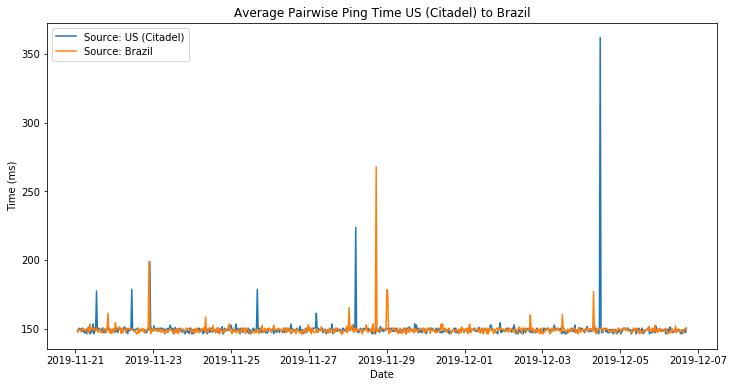

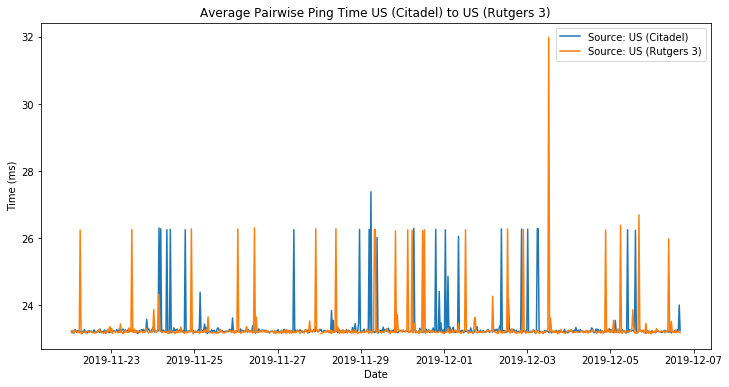

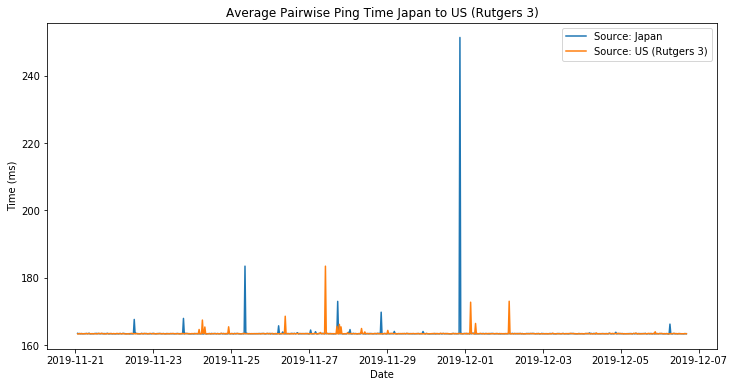

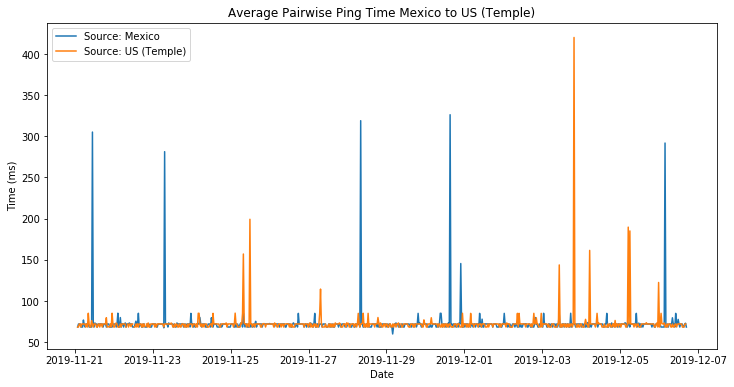

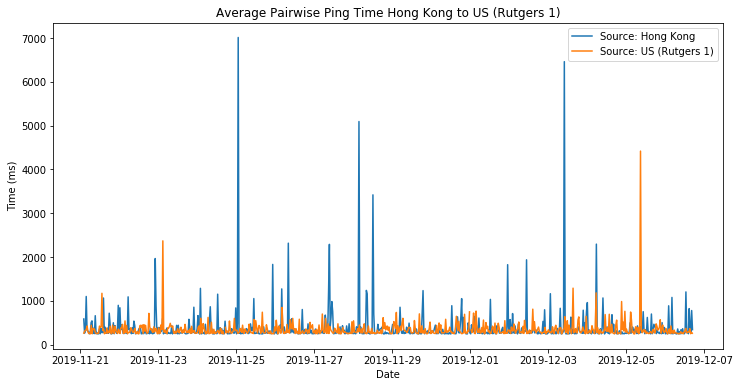

In [235]:
 for title, group in df[df['measure'] == 'ping'].groupby(['pair']):
    fig, ax = plt.subplots(figsize=(12, 6))
    legend = []
    
    
    
    for t, g in group.groupby(['src_id']):
        plt.plot(g['time'].sort_values(), g['avg_ping_time'])
        legend.append(f'Source: {node_loc[t]}')
        
    ax.legend(legend)
    ax.set_xlabel('Date')
    ax.set_ylabel('Time (ms)')
    ax.set_title(f'Average Pairwise Ping Time {node_pairs[title]}')
    

### Plotting number of hops for each pair

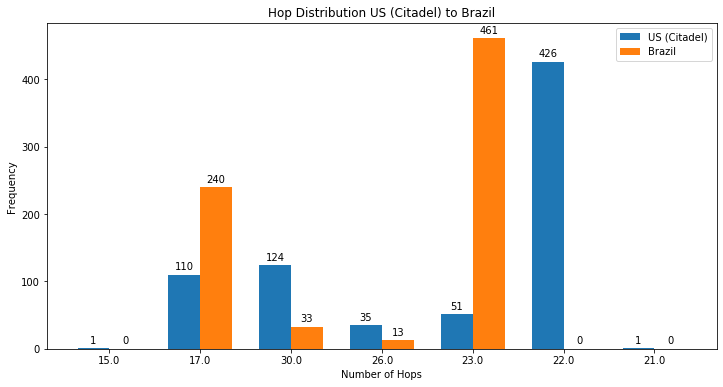

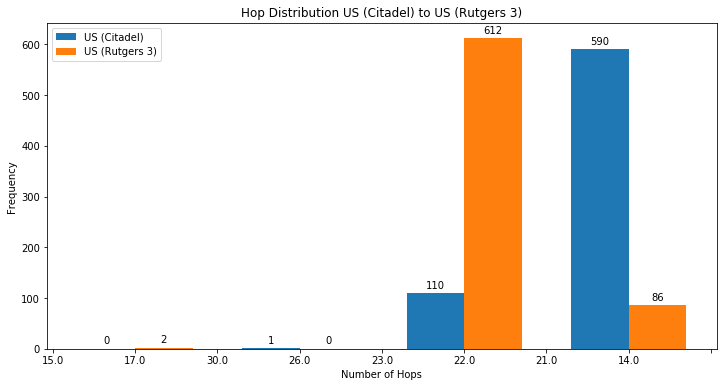

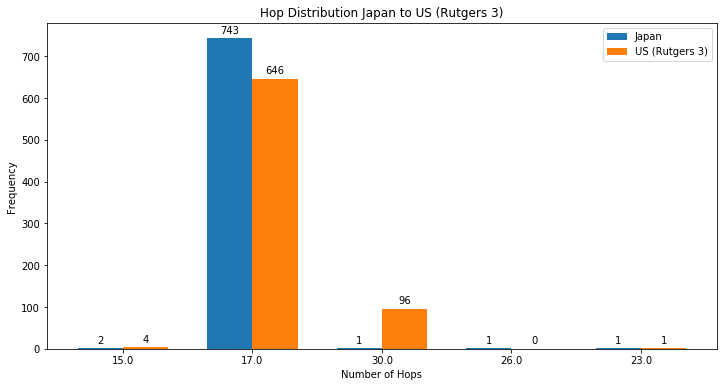

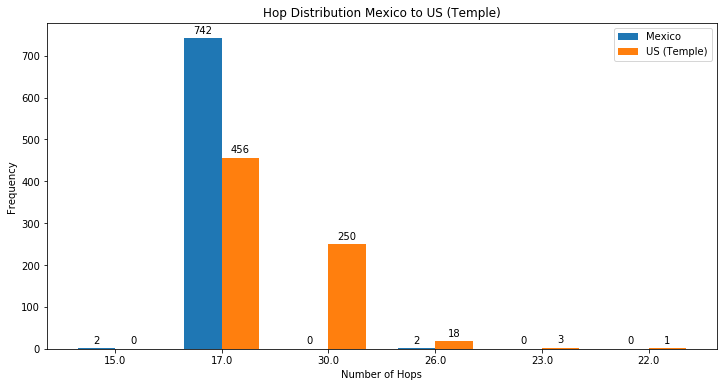

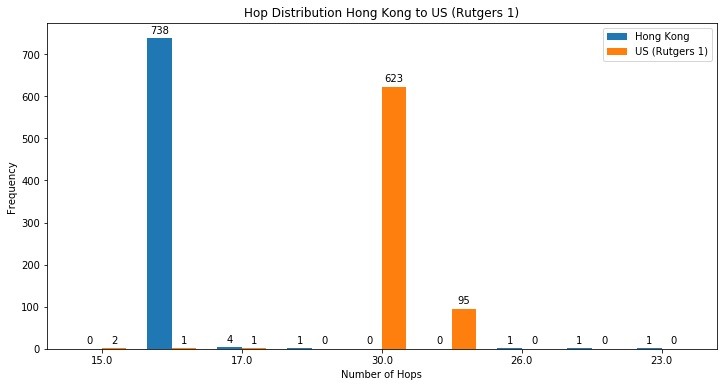

In [231]:
for title, group in df[df['measure'] == 'traceroute'].groupby(['pair']):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    hop_values = group['num_hops'].unique().tolist()
    hop_values.sort()
    width = 0.35
    
    rect1 = None
    rect2 = None
    
    for i, (t, g) in enumerate(group.groupby(['src_id'])):
        counters = {k:0 for k in hop_values}
        x = np.arange(len(counters.keys()))
        for row in g['num_hops']:
            counters[row] += 1
        
        if i == 0:
            rect1 = ax.bar(x - width / 2, counters.values(), width, label = node_loc[t])
        else:
            rect2 = ax.bar(x + width / 2, counters.values(), width, label = node_loc[t])
            
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rect1)
    autolabel(rect2)
    ax.legend()
    ax.set_xlabel('Number of Hops')
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(x_labels)
    ax.set_title(f'Hop Distribution {node_pairs[set(group["pair"].values).pop()]}')

### High level results of experiment

Ping timing statistics

|                        | US (Citadel) to Brazil | US (Citadel) to US (Rutgers 3) | Japan to US (Rutgers 3) | Mexico to US (Temple) | Hong Kong to US (Rutgers 1) |
| ---------------------- | :--------------------: | :----------------------------: | :---------------------: | :-------------------: | :-------------------------: |
| **Minimum ping time**  |        149.378         |             23.265             |         163.366         |        70.744         |           260.729           |
| **Average ping time**  |        149.634         |             23.353             |         163.529         |        70.842         |           378.509           |
| **Max ping time**      |        150.350         |             23.649             |         164.364         |        71.019         |           784.111           |
| **Standard deviation** |         0.521          |             0.184              |          0.527          |         0.276         |           142.709           |

In [9]:
def calc_gaps(group):
    
    # sort on time, shift column down, subtract the two for gap value
    group = group.assign(gaptime=group.sort_values(
        by=['time'])['time'] - group.sort_values(by=['time']).shift()['time'])
    
    # sort on time, shift column down, add a boolean if it exceeds the threshold
    group = group.assign(gap=group.sort_values(
        by=['time'])['time'] - group.sort_values(by=['time']).shift()['time'] > dt.timedelta(minutes=59))
   
    return group

# calculate the gaps for each node
df = df.groupby(['src_id', 'dest_id']).apply(calc_gaps)
# reset the indicies from the groupby function. columns will be grouped on both 'src_id' and 'dest_id',
# so drop them
df = df.reset_index(level=0, drop=True).reset_index(level=0, drop=True).reset_index().drop(columns=['index'])

# for title, group in df.groupby(['pair']):
    
#     print(f'---- Statistics for {title} ----')
#     print(f"{node_loc[title.split('-')[0]]} to {node_loc[title.split('-')[1].split(' ')[0]]}")
    
#     print(f'Mean minimum ping time: {group["min_ping_time"].describe()["mean"]}')
#     print(f'Mean average ping time: {group["avg_ping_time"].describe()["mean"]}')
#     print(f'Mean max ping time: {group["max_ping_time"].describe()["mean"]}')
#     print(f'Mean sd ping time: {group["sd_ping_time"].describe()["mean"]}')
#     print()

### Calculate CDF for packet loss and latency

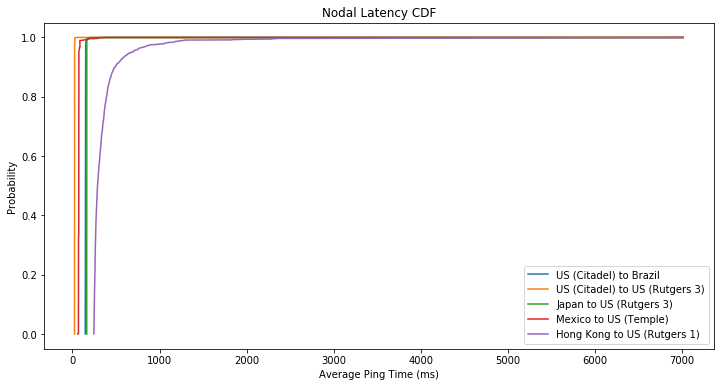

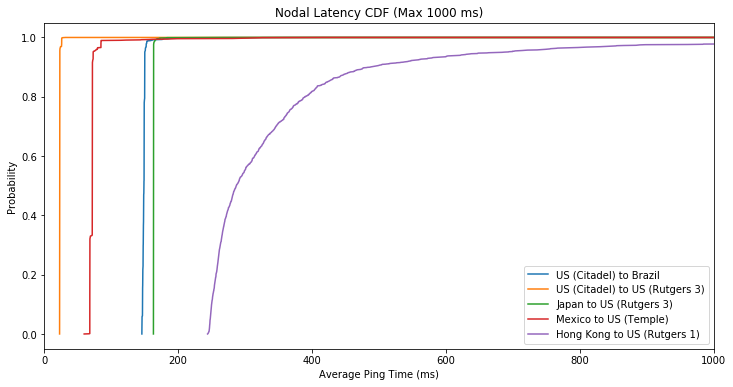

In [11]:
for i in range(2):
    # first group by each src, desc pair
    fig, ax = plt.subplots(figsize=(12, 6))
    legend = []
    
    if i == 1:
        ax.set_xlim(0, 1000)
    
    for title, group in df[df['measure'] == 'ping'].groupby(['pair']):

        # then group by the avg_ping_time
        stats_df = group.groupby('avg_ping_time')['avg_ping_time'].agg('count').pipe(pd.DataFrame).rename(
            columns = {'avg_ping_time': 'frequency'})

        # probability that the current time occurs
        stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
        # cumulative probability
        stats_df['cdf'] = stats_df['pdf'].cumsum()
        stats_df = stats_df.reset_index()

        # add the max value to each plot so that the CDF lines continue to end
        plt.plot(stats_df['avg_ping_time'].tolist()+[df['avg_ping_time'].max()],stats_df['cdf'].tolist()+[1])
        legend.append(node_pairs[title])
        
    if i == 0:
        ax.set_title('Nodal Latency CDF')
    else:
        ax.set_title('Nodal Latency CDF (Max 1000 ms)')
    ax.set_xlabel('Average Ping Time (ms)')
    ax.set_ylabel('Probability')
    ax.legend(legend)

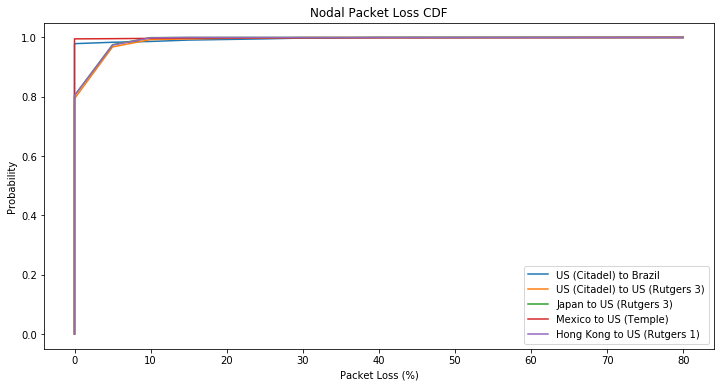

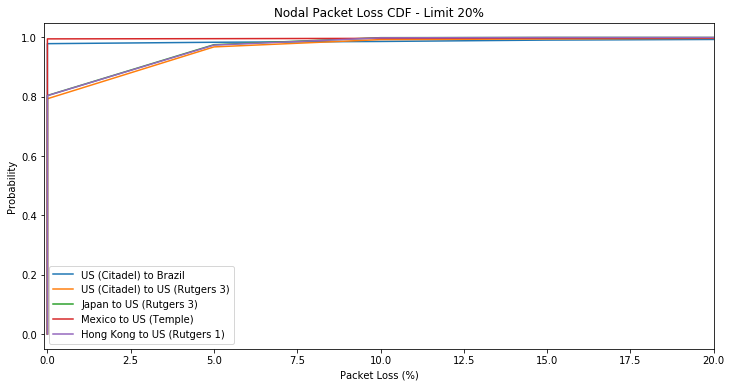

In [12]:
# first group by each src, desc pair
for i in range(2):
    fig, ax = plt.subplots(figsize=(12, 6))
    legend = []
    for title, group in df[df['measure'] == 'ping'].groupby(['pair']):

        # then group by the avg_ping_time
        stats_df = group.groupby('packet_loss')['packet_loss'].agg('count').pipe(pd.DataFrame).rename(
            columns = {'packet_loss': 'frequency'})

        # probability that the current time occurs
        stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
        # cumulative probability
        stats_df['cdf'] = stats_df['pdf'].cumsum()
        stats_df = stats_df.reset_index()

        # add the max value to each plot so that the CDF lines continue to end
        plt.plot([0] + stats_df['packet_loss'].tolist()+[df['packet_loss'].max()],[0] + stats_df['cdf'].tolist()+[1])

        legend.append(node_pairs[title])

    
    if i == 0:
        ax.set_title('Nodal Packet Loss CDF')
    else:
        ax.set_xlim(-.1, 20)
        ax.set_title('Nodal Packet Loss CDF - Limit 20%')
    ax.set_xlabel('Packet Loss (%)')
    ax.set_ylabel('Probability')
    ax.legend(legend)


In [13]:
df[df['measure'] == 'traceroute']

,avg_ping_time,dest_id,dest_name,filename,max_ping_time,measure,min_ping_time,packet_loss,pair,raw_data,sd_ping_time,src_id,src_name,time,gaptime,gap
0,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-28_13-33-42.txt,NaN,traceroute,NaN,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-28 13:33:42,00:02:24,False
1,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-22_20-13-52.txt,NaN,traceroute,NaN,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-22 20:13:52,00:11:09,False
2,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-25_14-51-15.txt,NaN,traceroute,NaN,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-25 14:51:15,00:05:37,False
4,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-30_21-10-49.txt,NaN,traceroute,NaN,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-30 21:10:49,00:03:34,False
7,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-12-04_06-34-12.txt,NaN,traceroute,NaN,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-12-04 06:34:12,00:03:42,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14647,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-23_06-56-32.txt,NaN,traceroute,NaN,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-23 06:56:32,00:02:44,False
14649,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-28_09-39-12.txt,NaN,traceroute,NaN,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-28 09:39:12,00:20:47,False
14650,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-25_01-23-21.txt,NaN,traceroute,NaN,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-25 01:23:21,00:00:05,False
14651,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-21_09-52-19.txt,NaN,traceroute,NaN,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-21 09:52:19,00:03:00,False


In [86]:
for title, group in df[df['measure'] == 'traceroute'].groupby(['pair']):
    data = set()
    with open(f'ips_{title}.txt', 'w') as file:
#         print(file.writelines(group['ips'].flatten().tolist()))
        ips = [x for x in group['ips'].to_numpy().flatten()]
        for x in ips:
            [data.add(y) for y in x]
    print(data)

{'200.143.253.77', '170.79.213.47', '205.186.224.49', '200.143.252.25', '200.143.253.81', '200.143.254.130', 'et-4-0-0.4079.rtsw.char.net.internet2.edu', '200.143.253.150', 'vpn.citadel.edu', '155.225.2.72', '170.79.213.61', '155.225.2.10', '162.252.70.122', '162.252.70.43', '200.143.252.26', 'et-4-1-0.4079.rtsw.atla.net.internet2.edu', '155.225.2.34', '205-186-224-50.generic.sclightrail.net', '200.143.252.109', 'pr-sp2-oi.bkb.rnp.br', 'p2-v103-araucaria-lapa.pop-pr.rnp.br', '200.143.253.149', 'et-3-3-0.4079.rtsw.atla.net.internet2.edu', '155.225.2.65', '200.143.255.142', '200.238.139.10', '*', '162.252.70.42', '200.143.255.89', '200.143.254.129', '170.79.213.2', '170.79.213.3', '64.57.28.61', '192.168.255.1', '200.143.252.62', 'mia2-mia1.bkb.rnp.br', '155.225.2.33', '200.143.252.61', '200.143.255.90', '200.143.252.137', 'sp2-mia1-atl.bkb.rnp.br', '205.186.224.50', '162.252.70.125', '170.79.213.18', 'et-4-0-0.469.rtsw.jack.net.internet2.edu', '200.17.202.195', '170.79.213.7', '200.143.